In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline

from graphviz  import Source
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>" 

In [2]:
train = pd.read_csv('titanic/train.csv')

In [3]:
test = pd.read_csv('titanic/test.csv')

In [4]:
X = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Fare'], axis = 1)
y = train['Survived']

In [5]:
X = pd.get_dummies(X)

In [6]:
X.isnull().mean()

Pclass        0.000000
Age           0.198653
SibSp         0.000000
Parch         0.000000
Sex_female    0.000000
Sex_male      0.000000
Embarked_C    0.000000
Embarked_Q    0.000000
Embarked_S    0.000000
dtype: float64

In [7]:
# здесь заполним пропущенные значения возрастов медианным значением:
X['Age'] = X['Age'].fillna(X['Age'].median())

In [8]:
# Создаем дерево и обучаем его

clf = tree.DecisionTreeClassifier(criterion = 'entropy')

In [9]:
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy')

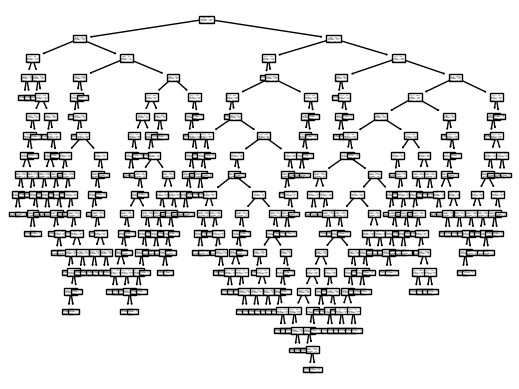

In [10]:
# Рисуем дерево

tree.plot_tree(clf);

In [10]:
# это пример переобучения модели. модель не решает задачу научиться классифицировать на 1 и 0
# здесь модель снижает энтропию до минимума пока не достигнит его

# это есть проблема переобучения, когда вместо того чтобы выявить общую закономерность, обобщить данные
# мы пытаемся безошибочно классифицировать каждое наблюдение в выборке:

# так можно посмотреть долю правильных ответов в нашей выборке:

clf.score(X,y)

0.936026936026936

In [11]:
# как бороться с проблемой переобучения:

# глубина обучения - сколько вопросов может задать дерево, чтобы наилучшим образом классифицировать

# или показывать два набора данных - обучающую и тестовую выборку:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [12]:
# обучим модель на train:

clf.fit(X_train, y_train)

# и выведем точность этого обучения:
clf.score(X_train, y_train)

0.9446308724832215

In [15]:
# а теперь проверим эту модель на тех данных, которые этот классификатор не видел: X_test

clf.score(X_test, y_test)

0.7389830508474576

In [13]:
# самый простой способ избежать проблему переобучения - задать дереву максимальную глубину (ограничить ее)

clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=5)

In [17]:
# обучим классификатор на train

clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

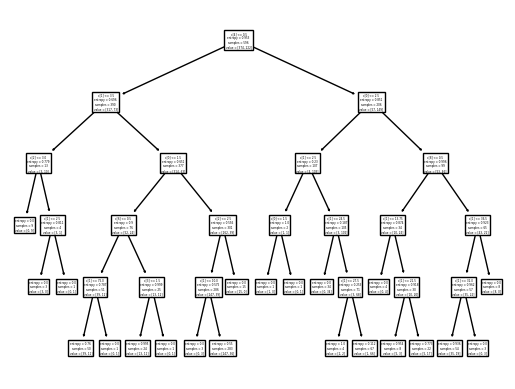

In [18]:
# теперь дерево содержит заданной количество = 5 уровней:

tree.plot_tree(clf);

In [19]:
# видим что классификатор стал работать хуже на train (в прошлый раз было 94% правильных ответов)
clf.score(X_train, y_train)

0.8523489932885906

In [20]:
# зато на тестовых данных - которых классификатор не видел - он стал работать лучше (в прошлый раз было 74% правильных ответов)
clf.score(X_test, y_test)

0.7864406779661017

# Обучение_переобучение_недообучение_кросвалидация

In [21]:
# Заводим пустой итоговый датафрейм в который будем собирать глубины и скоры:

scores_data = pd.DataFrame()

In [22]:
max_depth_values = range(1, 100)

In [23]:
for depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    # создаем строчку для итогового датафрейма:
    temp_scores_data = pd.DataFrame({'max_depth': [depth],  'train_score': [train_score], 'test_score': [test_score]})
    
    # добавляем в итоговый датафрейм:
    scores_data = pd.concat([scores_data, temp_scores_data])

In [24]:
scores_data

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.832215,0.806780
0,4,0.835570,0.806780
0,5,0.852349,0.793220
...,...,...,...
0,95,0.944631,0.738983
0,96,0.944631,0.749153
0,97,0.944631,0.745763
0,98,0.944631,0.738983


In [25]:
# функция melt преобразует итоговый датафрейм

scores_data = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
        var_name='type_score', value_name='score')

scores_data


,max_depth,type_score,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.832215
3,4,train_score,0.835570
4,5,train_score,0.852349
...,...,...,...
193,95,test_score,0.738983
194,96,test_score,0.749153
195,97,test_score,0.745763
196,98,test_score,0.738983


<Axes: xlabel='max_depth', ylabel='score'>

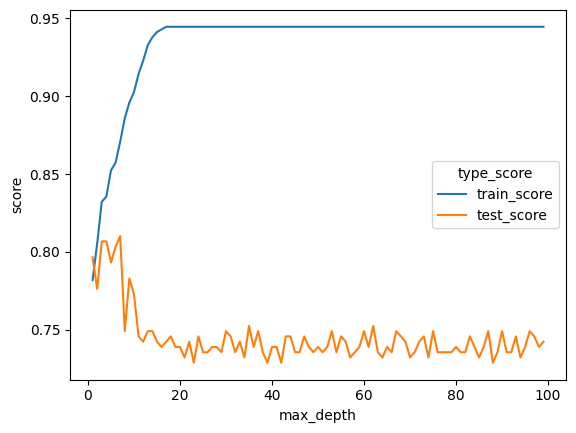

In [26]:
# визуализируем этот датафрейм:

sns.lineplot(data = scores_data, 
             x=scores_data['max_depth'], 
             y=scores_data['score'], 
             hue = 'type_score', 
             #style="type_score", 
             legend='full')

# Кросс валидация

In [26]:
# Проблема данных заключается в том что мы один раз зафитили модель и больше не меняли набор данных

In [27]:
from sklearn.model_selection import cross_val_score

In [28]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)

In [29]:
# кросс валидация на пяти фолдах только на выборке train:
# показана точность для валидационной части каждого фолда

cross_val_score(clf, X_train, y_train, cv = 5)

array([0.78333333, 0.86554622, 0.7394958 , 0.75630252, 0.86554622])

In [30]:
# из этих значений можно получить среднее для модели: на кросс валидации
cross_val_score(clf, X_train, y_train, cv = 5).mean()

0.8003641456582633

In [31]:
# теперь в итоговый датафрейм будем добавлять средние данные кросс валидации:

In [31]:
# Заводим пустой итоговый датафрейм в который будем собирать глубины и скоры:

scores_data = pd.DataFrame()

In [32]:
# определяем диапазон глубин обучения:
max_depth_values = range(1, 100)

In [33]:
for depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=depth)
    clf.fit(X_train,y_train)
    
    # получаем train_score:
    train_score = clf.score(X_train, y_train)
    
    # получаем test_score:
    test_score = clf.score(X_test, y_test)
    
    # И ЕЩЕ ДОБАВЛЯЕМ cross_val_score ДЛЯ КАЖДОЙ ГЛУБИНЫ ДЕРЕВА CLF:
    cross_val = cross_val_score(clf, X_train, y_train, cv = 5).mean()
    
    
    # создаем строчку для итогового датафрейма:
    temp_scores_data = pd.DataFrame({'max_depth': [depth],
                                     'train_score': [train_score],
                                     'test_score': [test_score],
                                    'cross_val_score': [cross_val]})
    
    # добавляем в итоговый датафрейм:
    scores_data = pd.concat([scores_data, temp_scores_data])

In [35]:
scores_data

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.775238
0,3,0.832215,0.806780,0.793627
0,4,0.835570,0.806780,0.802045
0,5,0.852349,0.786441,0.802045
...,...,...,...,...
0,95,0.944631,0.735593,0.770196
0,96,0.944631,0.749153,0.770196
0,97,0.944631,0.738983,0.768515
0,98,0.944631,0.745763,0.768515


In [35]:
# функция melt преобразует итоговый датафрейм

scores_data = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
        var_name='type_score', value_name='score')

scores_data

,max_depth,type_score,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.832215
3,4,train_score,0.835570
4,5,train_score,0.852349
...,...,...,...
292,95,cross_val_score,0.768515
293,96,cross_val_score,0.761793
294,97,cross_val_score,0.771877
295,98,cross_val_score,0.763473


<Axes: xlabel='max_depth', ylabel='score'>

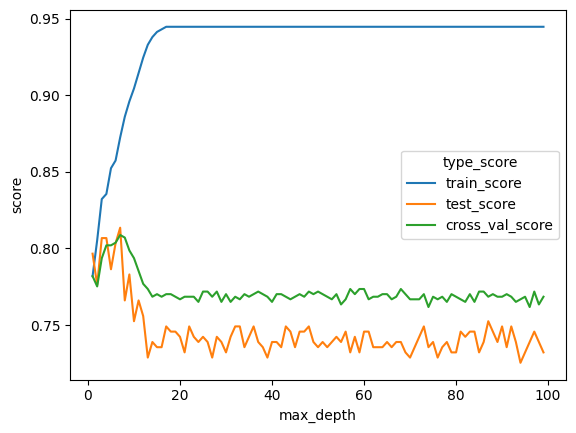

In [36]:
# визуализируем этот датафрейм:

sns.lineplot(data = scores_data, 
             x=scores_data['max_depth'], 
             y=scores_data['score'], 
             hue = 'type_score', 
             #style="type_score", 
             legend='full')


In [37]:
# теперь определим при какой глубине достигался максимальный score на более точной кросс-валидации:

# сначала отберем только type_score == cross_val_score:
only_cross_val_scores = scores_data[(scores_data['type_score'] == 'cross_val_score')]

only_cross_val_scores

,max_depth,type_score,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.775238
200,3,cross_val_score,0.793627
201,4,cross_val_score,0.802045
202,5,cross_val_score,0.802045
...,...,...,...
292,95,cross_val_score,0.768515
293,96,cross_val_score,0.761793
294,97,cross_val_score,0.771877
295,98,cross_val_score,0.763473


In [38]:
# теперь найдем максимальное среди only_cross_val_scores:

only_cross_val_scores['score'].max()

0.8087955182072829

In [39]:
# какой глубине обучения это соответствует???

only_cross_val_scores[only_cross_val_scores['score'] == only_cross_val_scores['score'].max()]

,max_depth,type_score,score
204,7,cross_val_score,0.808796


In [40]:
# сейчас уже зная глубину обучения при которой получается лучший scor на кросс-валидации:

# можно сделать классификатор для train уже с этой глубиной:

best_clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)

In [41]:
# теперь этот классификатор можно проверить на тестовых данных:

cross_val_score(best_clf, X_test, y_test, cv = 5).mean()

0.8169491525423729

# Ключевая функция для обучения моделей GridSearchCV

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [14]:
from sklearn.model_selection import GridSearchCV

In [45]:
# grid_search_cv_clf = GridSearchCV()

# ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# Cell In[44], line 1
# ----> 1 grid_search_cv_clf = GridSearchCV()

# TypeError: GridSearchCV.__init__() missing 2 required positional arguments: 'estimator' and 'param_grid'

In [15]:
# GridSearchCV() требуются обязательные аргументы:
    
# 1. estimator:
    
clf = tree.DecisionTreeClassifier()


# 2. и param_grid - словарь с параметрами из 'clf?' - которые можно менять
# (задаем разные критерии и разную глубину - для выбора)

parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,30)}

In [29]:
# clf? здесь можно смотреть все доступные параметры

In [16]:
# также передаем количество фолдов кросс валидации

grid_search_cv_clf = GridSearchCV(clf, parameters, cv = 5)

In [5]:
# GridSearchCV позволяет взять нам классификатор tree.DecisionTreeClasifier

# взять набор параметров, комбинации которых мы ходим сраванивать между собой и выбрать наилучшие

# взять настройки кросс валидации

grid_search_cv_clf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [17]:
# и дальше обучиться на некоторых данных X_train, y_train

grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [18]:
# и выбрать такие параметры которые для заданной метрики (по умолчанию стоит accuracy) - будут максимальными:
# на кросс-валидационном множестве (не просто на обучающей выборке, а именно на кросс-валидации)

grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 3}

In [19]:
# также можно сразу перейти к дереву с лучшими параметрами:


best_clf = grid_search_cv_clf.best_estimator_

In [20]:
# здесь мы уже имеем дело с деревом с подобранными наилучшими параметрами:

best_clf

DecisionTreeClassifier(max_depth=3)

In [21]:
# и можем проверить заданную метрку (по умолчанию стоит accuracy) на тестовых данных:

best_clf.score(X_test, y_test)

0.8067796610169492

In [22]:
# когда есть дисбаланс классов accuracy не подходит, нужно смотреть на другие метрики:

# precision.score

# recall.score



# для этого сначала - получаем предсказанные данные y_pred:

y_pred = best_clf.predict(X_test)

In [23]:
# получаем precision.score:

from sklearn.metrics import precision_score

precision_score(y_test, y_pred, average='macro')

0.8201701756299771

In [24]:
# получаем recall.score:

from sklearn.metrics import recall_score

recall_score(y_test, y_pred, average='macro')

0.7795238095238095

# ВЕРОЯТНОСТЬ ПРЕДСКАЗАНИЯ

In [ ]:
# полученное y_pred - это "1" и "0" - по умолчанию вероятность конвертируется в класс по порогу 0.5

# каждое наблюдение "проваливается" по своей ветке дерева до конечного уровня и там есть разделения классов
# отсюда возникает вероятность предсказания

In [27]:
# чтобы извлечь именно вероятность предсказания :

y_predicted_brobability = best_clf.predict_proba(X_test)
# y_predicted_brobability

<Axes: >

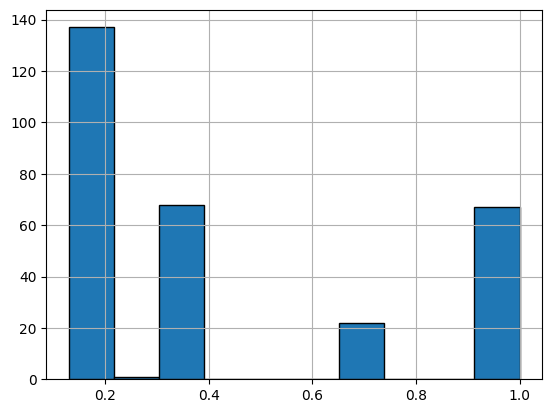

In [55]:
pd.Series(y_predicted_brobability[:,1]).hist(edgecolor = 'black')

In [56]:
# Если мы хотим изменить порог с 0.5 на другое значение:

# например если мы меняем порог на 0.8 - то мы считаем выжившими только тех пассажиров, для которых вероятность выше 0.8
# (это лучше в случае если у нас ограниченное количество спасательных лодок и надо отправить их к гарантированно выжившим)

np.where(y_predicted_brobability[:,1] > 0.8, 1, 0)

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0])

In [57]:
# Это получается новый y_pred c порогом 0.8:

y_pred_0_8 = np.where(y_predicted_brobability[:,1] > 0.8, 1, 0)

In [58]:
# Посчитаем precision для старого y_pred (c порогом по умолчанию в 0.5) и для нового y_pred_0_8:

print('Порог 0.5, precision: ', precision_score(y_test, y_pred, average='macro'))
print('Порог 0.8, precision: ', precision_score(y_test, y_pred_0_8, average='macro'))

# Посчитаем recall:

print('Порог 0.5, recall: ', recall_score(y_test, y_pred, average='macro'))
print('Порог 0.8, recall: ', recall_score(y_test, y_pred_0_8, average='macro'))

Порог 0.5, precision:  0.8201701756299771
Порог 0.8, precision:  0.8258379156847342
Порог 0.5, recall:  0.7795238095238095
Порог 0.8, recall:  0.7370238095238095


In [59]:
# А если бы мы хотели условно считать выжившими людей с меньшей вероятностью выжить по нашему предсказанию:
# зададим порог в 0.2

# например в том случае если количество спасательных лодок не ограничено и мы хотим послать их все

y_pred_0_2 = np.where(y_predicted_brobability[:,1] > 0.2, 1, 0)

In [79]:
# Посчитаем precision для старого y_pred (c порогом по умолчанию в 0.5) и для нового y_pred_0_2:

print('Порог 0.5, precision: ', precision_score(y_test, y_pred, average='macro'))
print('Порог 0.2, precision: ', precision_score(y_test, y_pred_0_2, average='macro'))

# Посчитаем recall:

print('Порог 0.5, recall: ', recall_score(y_test, y_pred, average='macro'))
print('Порог 0.2, recall: ', recall_score(y_test, y_pred_0_2, average='macro'))

Порог 0.5, precision:  0.8201701756299771
Порог 0.2, precision:  0.7911623394622562
Порог 0.5, recall:  0.7795238095238095
Порог 0.2, recall:  0.8001190476190476


# Меньше precision - значит больше recall и наоборот

## Чтобы выбрать лучшую отсечку и минимизировать ошибки первого и второго рода надо строить ROC-кривую

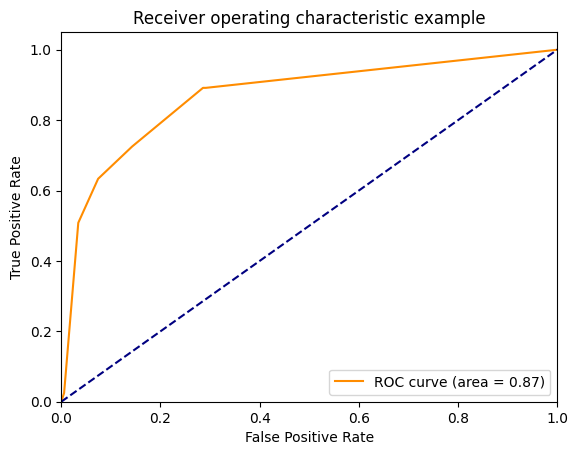

In [85]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_brobability[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Задача

In [ ]:
# Файл здесь - train_data_tree.csv

# Скачайте набор данных с тремя переменными: sex, exang, num. Представьте, 
# что при помощи дерева решений мы хотим классифицировать есть или 
# нет у пациента заболевание сердца (переменная num), основываясь 
# на двух признаках: пол (sex) и наличие/отсутсвие стенокардии (exang). 


# Обучите дерево решений на этих данных, используйте entropy 
# в качестве критерия.


# Укажите, чему будет равняться значение Information Gain для переменной, которая будет помещена в корень дерева.

# В ответе необходимо указать число с точностью 3 знака после запятой.

In [60]:
df = pd.read_csv('train_data_tree.csv')

In [61]:
df

,sex,exang,num
0,1,1,1
1,1,1,1
2,1,0,1
3,1,0,0
4,1,0,1
...,...,...,...
233,1,0,0
234,1,1,0
235,1,0,1
236,1,1,1


In [62]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [63]:
X_train = df[['sex', 'exang']]
y_train = df['num']

In [64]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

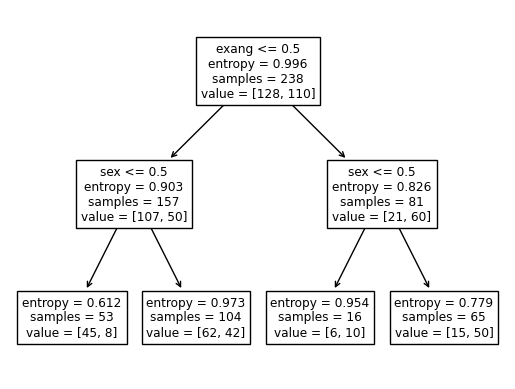

In [67]:
# Рисуем дерево

tree.plot_tree(clf, feature_names = ['sex', 'exang']);

In [4]:
-(107/157)*np.log2(107/157) - (50/157)*np.log2(50/157)

0.9027113410339267

In [85]:
# значение Information Gain для переменной, которая будет помещена в корень дерева

# будет равняться энтропии исходной 0.996 минус Е (Y | x) - энтропии после разделения с весовыми коэффициентами 

# энтропия после разделения это Е1 - энтропия получившияся в левой ветке, и Е2 - энтропия получившаяся в правой ветке
# E(Y | x) = (n1 / N) * E1 + (n2 / N) * E2

# где E1 и Е2 это энтропия разделения на классы в этом листе

# а n1 и n2 - это разделенные события, а N это все события на самом верху в данном случае:
    
E1 = 0.903

E2 = 0.826

E_Y_X = (157/238) * E1 + (81/238) * E2
IG = 0.996 - E_Y_X
IG

0.11920588235294116

In [83]:
IG = 0.996 - (128*E1 + 110*E2)/238
IG

0.12858823529411756

# Задача

In [ ]:
# Теперь, создав дерево, давайте обучим его и попробуем что-нибудь предсказать!

# Для начала опробуем наше дерево на классическом наборе iris, где собраны данные 
# о длине, ширине чашелистиков и лепестков ирисов и их принадлежности к виду. 
# В sklearn он уже встроен, что довольно удобно.

# Итак, вам даны 2 numpy эррея с измеренными признаками ирисов и их принадлежностью 
# к виду. Сначала попробуем примитивный способ с разбиением данных на 2 датасэта. 
# Используйте функцию train_test_split для разделения имеющихся данных на 
# тренировочный и тестовый наборы данных, 75% и 25% соответственно.
# Затем создайте дерево dt с параметрами по умолчанию и обучите его на 
# тренировочных данных, а после предскажите классы, к которым принадлежат 
# данные из тестовой выборки, сохраните результат предсказаний в переменную 
# predicted.

In [24]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
dt = tree.DecisionTreeClassifier()

In [27]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
predicted = dt.predict(X_test)

In [29]:
predicted

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

In [30]:
y_test

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

In [ ]:
# https://www.machinelearningmastery.ru/how-to-tune-a-decision-tree-f03721801680/ 
    
# про min samples split и min samples leaf